## First training and testing on ESC-50

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import self-implemented torch dataset
from datasets import ESCDataset

In [2]:
train_data = ESCDataset(root='ESC50', 
                        esc50=True, 
                        val_fold=4,
                        train=True,
                        download=True)
valid_data = ESCDataset(root='ESC50', 
                        esc50=True, 
                        val_fold=4,
                        train=False,
                        download=False)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

Download not needed, files already on disk.


100%|██████████| 400/400 [00:13<00:00, 30.60it/s]

train data length 1600
valid data length 400


In [3]:
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.5864284908771515


  4%|▍         | 1/25 [00:03<01:16,  3.20s/it]

Epoch - 1 Valid-Loss : 2.1119921922683718 Valid-Accuracy : 0.3975
Epoch - 2 Train-Loss : 1.336970313191414


  8%|▊         | 2/25 [00:06<01:08,  2.99s/it]

Epoch - 2 Valid-Loss : 1.201439938545227 Valid-Accuracy : 0.665
Epoch - 3 Train-Loss : 0.8341393706202507


 12%|█▏        | 3/25 [00:08<01:04,  2.92s/it]

Epoch - 3 Valid-Loss : 1.100340690612793 Valid-Accuracy : 0.695
Epoch - 4 Train-Loss : 0.616164080798626
Epoch - 4 Valid-Loss : 1.0532919144630433 Valid-Accuracy : 0.71


 20%|██        | 5/25 [00:14<00:57,  2.87s/it]

Epoch - 5 Train-Loss : 0.40303198486566544
Epoch - 5 Valid-Loss : 0.9767934048175811 Valid-Accuracy : 0.7275


 24%|██▍       | 6/25 [00:17<00:54,  2.86s/it]

Epoch - 6 Train-Loss : 0.3073073272034526
Epoch - 6 Valid-Loss : 0.9854271149635315 Valid-Accuracy : 0.7225


 28%|██▊       | 7/25 [00:20<00:51,  2.85s/it]

Epoch - 7 Train-Loss : 0.24862042743712665
Epoch - 7 Valid-Loss : 1.0466725373268126 Valid-Accuracy : 0.7275


 32%|███▏      | 8/25 [00:23<00:48,  2.85s/it]

Epoch - 8 Train-Loss : 0.23957809142768383
Epoch - 8 Valid-Loss : 0.9313073182106018 Valid-Accuracy : 0.745


 36%|███▌      | 9/25 [00:25<00:45,  2.85s/it]

Epoch - 9 Train-Loss : 0.16946158241480588
Epoch - 9 Valid-Loss : 0.7322996211051941 Valid-Accuracy : 0.7925
Changed learning rate to 2e-05


 40%|████      | 10/25 [00:28<00:42,  2.85s/it]

Epoch - 10 Train-Loss : 0.07843193956650793
Epoch - 10 Valid-Loss : 0.569569569081068 Valid-Accuracy : 0.85


 44%|████▍     | 11/25 [00:31<00:39,  2.85s/it]

Epoch - 11 Train-Loss : 0.04061022382229566
Epoch - 11 Valid-Loss : 0.5345066750049591 Valid-Accuracy : 0.8575


 48%|████▊     | 12/25 [00:34<00:37,  2.85s/it]

Epoch - 12 Train-Loss : 0.029007607265375556
Epoch - 12 Valid-Loss : 0.5055168084800243 Valid-Accuracy : 0.8625


 52%|█████▏    | 13/25 [00:37<00:34,  2.85s/it]

Epoch - 13 Train-Loss : 0.027925776871852576
Epoch - 13 Valid-Loss : 0.4798100823163986 Valid-Accuracy : 0.875


 56%|█████▌    | 14/25 [00:40<00:31,  2.85s/it]

Epoch - 14 Train-Loss : 0.023102150936610995
Epoch - 14 Valid-Loss : 0.4831217217445374 Valid-Accuracy : 0.8575


 60%|██████    | 15/25 [00:43<00:28,  2.85s/it]

Epoch - 15 Train-Loss : 0.024385256241075695
Epoch - 15 Valid-Loss : 0.4929547902941704 Valid-Accuracy : 0.8725


 64%|██████▍   | 16/25 [00:45<00:25,  2.85s/it]

Epoch - 16 Train-Loss : 0.020951733286492528
Epoch - 16 Valid-Loss : 0.4719224178791046 Valid-Accuracy : 0.8775


 68%|██████▊   | 17/25 [00:48<00:22,  2.85s/it]

Epoch - 17 Train-Loss : 0.015356979235075414
Epoch - 17 Valid-Loss : 0.45470117032527924 Valid-Accuracy : 0.8725


 72%|███████▏  | 18/25 [00:51<00:19,  2.85s/it]

Epoch - 18 Train-Loss : 0.018995852931402622
Epoch - 18 Valid-Loss : 0.4758079291135073 Valid-Accuracy : 0.8625


 76%|███████▌  | 19/25 [00:54<00:17,  2.85s/it]

Epoch - 19 Train-Loss : 0.014217437403276563
Epoch - 19 Valid-Loss : 0.47924399975687265 Valid-Accuracy : 0.87
Changed learning rate to 2e-06


 80%|████████  | 20/25 [00:57<00:14,  2.85s/it]

Epoch - 20 Train-Loss : 0.0163137574843131
Epoch - 20 Valid-Loss : 0.4785107234120369 Valid-Accuracy : 0.8675


 84%|████████▍ | 21/25 [01:00<00:11,  2.85s/it]

Epoch - 21 Train-Loss : 0.013894013864919542
Epoch - 21 Valid-Loss : 0.4578681120276451 Valid-Accuracy : 0.875


 88%|████████▊ | 22/25 [01:02<00:08,  2.85s/it]

Epoch - 22 Train-Loss : 0.013312456752173603
Epoch - 22 Valid-Loss : 0.44216791555285456 Valid-Accuracy : 0.87


 92%|█████████▏| 23/25 [01:05<00:05,  2.85s/it]

Epoch - 23 Train-Loss : 0.012676749997772276
Epoch - 23 Valid-Loss : 0.48592985183000564 Valid-Accuracy : 0.865


 96%|█████████▌| 24/25 [01:08<00:02,  2.85s/it]

Epoch - 24 Train-Loss : 0.012158254433888942
Epoch - 24 Valid-Loss : 0.45896679371595384 Valid-Accuracy : 0.8825


100%|██████████| 25/25 [01:11<00:00,  2.85s/it]

Epoch - 25 Train-Loss : 0.012576895277015865
Epoch - 25 Valid-Loss : 0.465180604159832 Valid-Accuracy : 0.8675


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


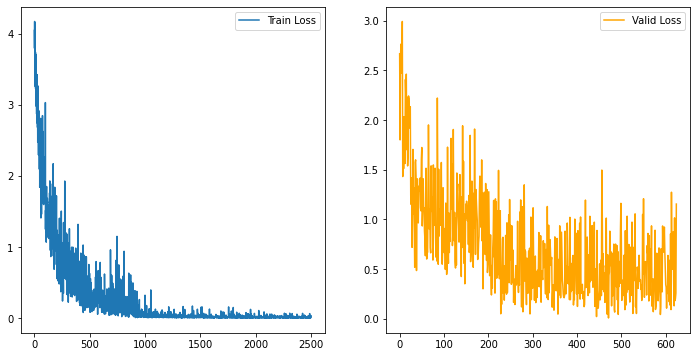

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
